=== Dataset Overview ===
Total games simulated: 15,000
Unique strategy pairs: 30

First 5 rows:
  Player1_Strategy Player2_Strategy  Player1_Score  Player2_Score   Winner  \
0           Random   Simple Minimax             13             35  Player2   
1           Random   Simple Minimax             26             22  Player1   
2           Random   Simple Minimax             16             32  Player2   
3           Random   Simple Minimax             12             36  Player2   
4           Random   Simple Minimax             15             33  Player2   

   Moves  Time_Seconds  
0     25         0.956  
1     45         1.831  
2     38         1.493  
3     27         1.432  
4     29         1.291  

=== Basic Statistics ===
Average scores:
       Player1_Score  Player2_Score
count    15000.00000    15000.00000
mean        24.71380       23.28620
std         10.46467       10.46467
min          3.00000        3.00000
25%         16.00000       14.00000
50%         26.00000       

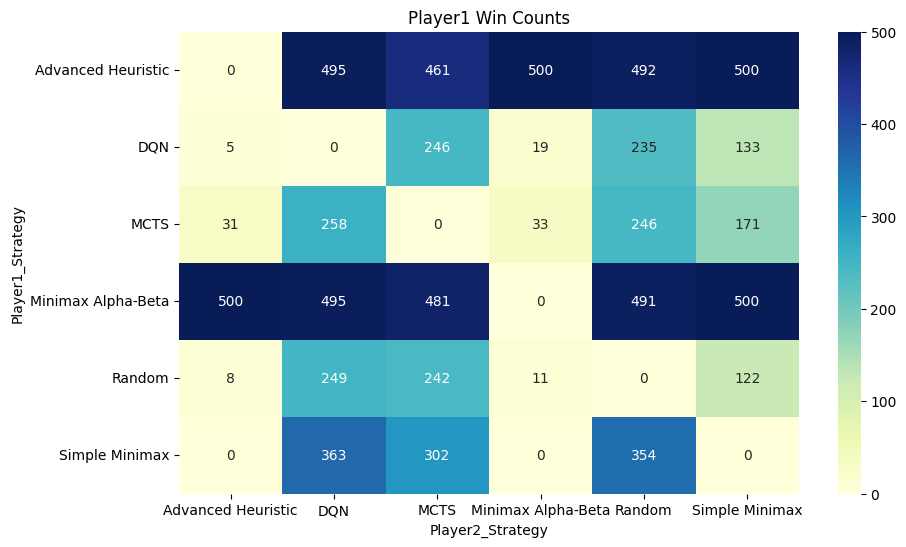

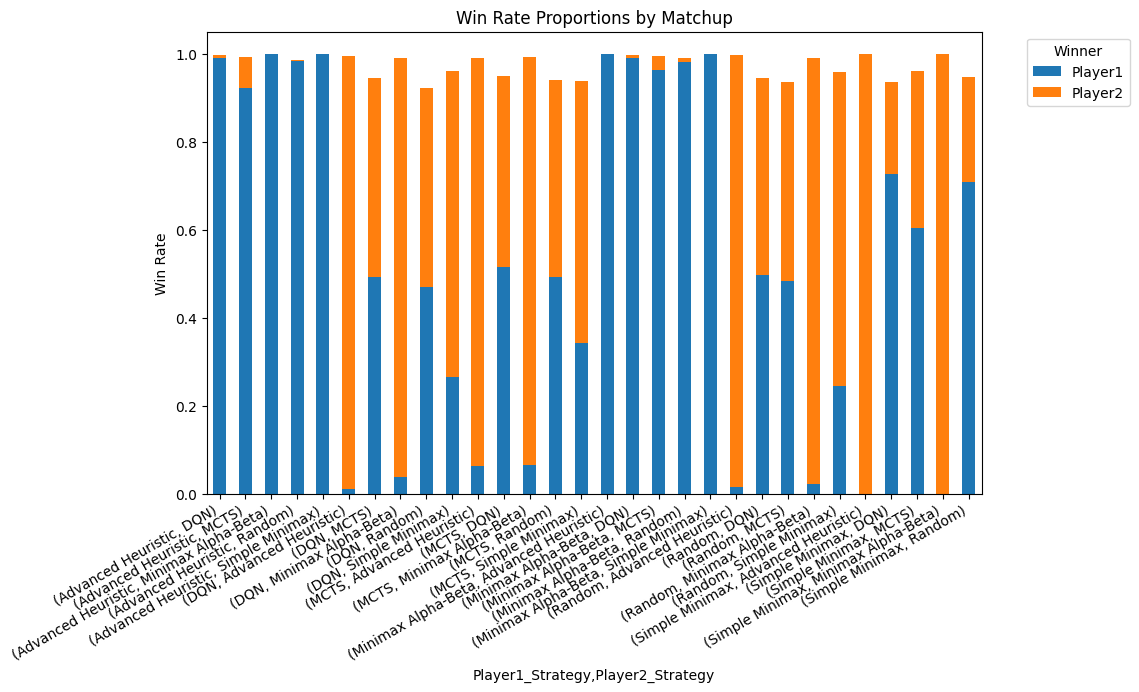

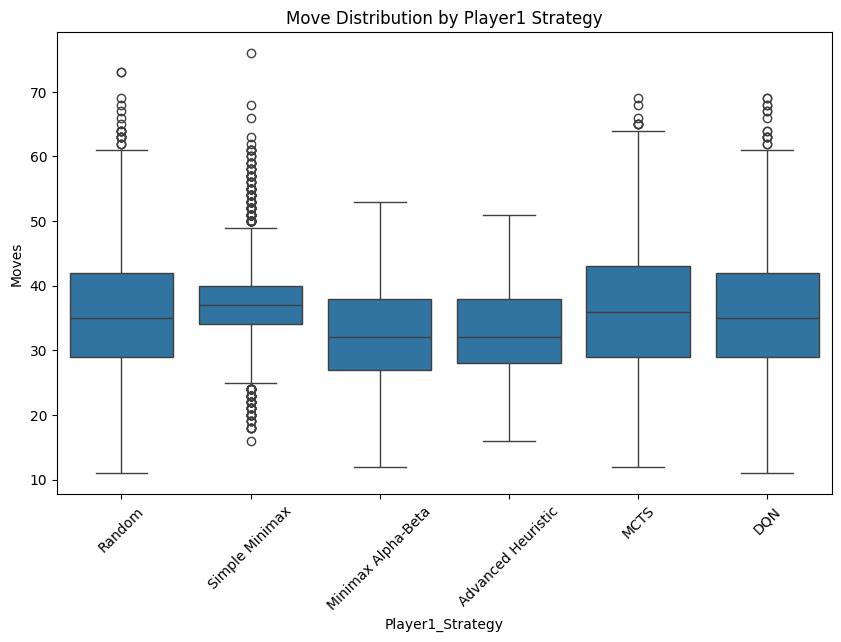

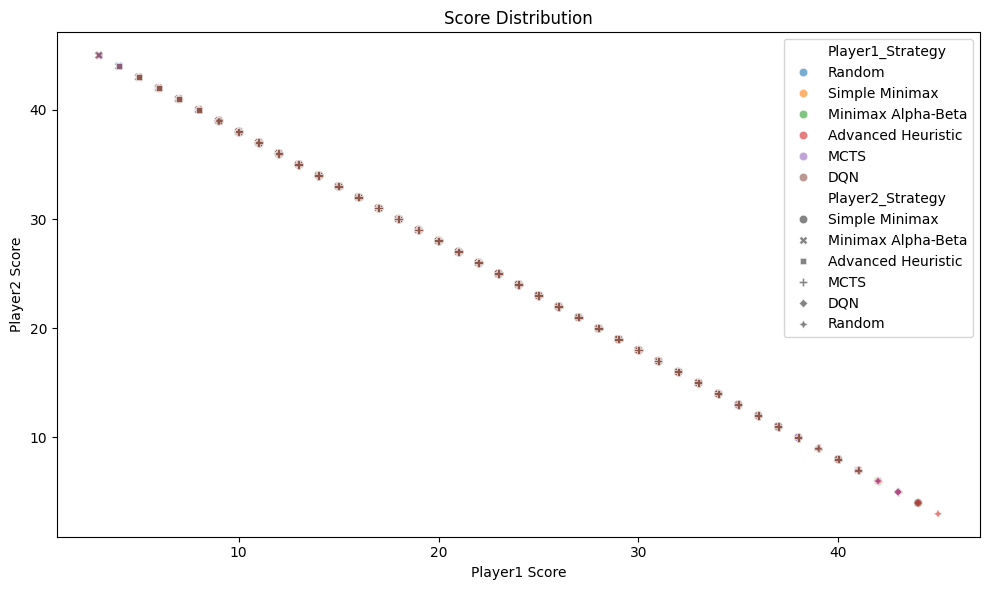


=== Advanced Metrics ===

Matchup Statistics:
                                       Avg_Score_Diff  Moves  Time_Seconds  \
Player1_Strategy   Player2_Strategy                                          
Advanced Heuristic DQN                         25.608   29.0      7.237688   
                   MCTS                        22.396   29.0     11.186880   
                   Minimax Alpha-Beta           4.000   38.0      4.328472   
                   Random                      25.992   29.0      7.313756   
                   Simple Minimax              22.000   32.0      6.833076   
DQN                Advanced Heuristic         -23.756   30.0      5.590400   
                   MCTS                         1.184   40.0      8.634768   
                   Minimax Alpha-Beta         -21.748   30.0      0.476202   
                   Random                       0.348   41.0      0.001526   
                   Simple Minimax              -6.040   39.0      1.478832   
MCTS             

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(csv_path):
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Basic info
    print("=== Dataset Overview ===")
    print(f"Total games simulated: {len(df):,}")
    print(f"Unique strategy pairs: {df[['Player1_Strategy', 'Player2_Strategy']].drop_duplicates().shape[0]}")
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Basic statistics
    print("\n=== Basic Statistics ===")
    print("Average scores:")
    print(df[['Player1_Score', 'Player2_Score']].describe())
    
    print("\nGame duration stats:")
    print(df[['Moves', 'Time_Seconds']].describe())
    
    # Win rate analysis
    print("\n=== Win Rate Analysis ===")
    
    # Overall win rates
    overall_win_rates = df['Winner'].value_counts(normalize=True)
    print(f"\nOverall Win Rates:\n{overall_win_rates}")
    
    # Win rates by strategy pair
    strategy_win_rates = df.groupby(['Player1_Strategy', 'Player2_Strategy'])['Winner'] \
                         .value_counts(normalize=True) \
                         .unstack() \
                         .fillna(0)
    
    print("\nWin Rates by Strategy Matchup:")
    print(strategy_win_rates)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    
    # Heatmap of Player1 win rates
    print("\nGenerating visualizations...")
    heatmap_data = df[df['Winner'] == 'Player1'].groupby(
        ['Player1_Strategy', 'Player2_Strategy']
    ).size().unstack().fillna(0)
    
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu')
    plt.title('Player1 Win Counts')
    
    # Win rate comparison
    plt.figure(figsize=(10, 6))
    strategy_win_rates = df.groupby(['Player1_Strategy', 'Player2_Strategy'])['Winner'] \
        .value_counts(normalize=True) \
        .unstack() \
        .fillna(0)
    strategy_win_rates[['Player1', 'Player2']].plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Win Rate Proportions by Matchup')
    plt.ylabel('Win Rate')
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Winner", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Move distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Player1_Strategy', y='Moves', data=df)
    plt.title('Move Distribution by Player1 Strategy')
    plt.xticks(rotation=45)
    
    # Score comparison
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Player1_Score', y='Player2_Score', 
                    hue='Player1_Strategy', style='Player2_Strategy',
                    data=df, alpha=0.6)
    plt.title('Score Distribution')
    plt.xlabel('Player1 Score')
    plt.ylabel('Player2 Score')
    
    plt.tight_layout()
    plt.savefig('mancala_analysis.png')
    plt.show()
    
    # Advanced metrics
    print("\n=== Advanced Metrics ===")
    df['Score_Difference'] = df['Player1_Score'] - df['Player2_Score']
    
    matchup_stats = df.groupby(['Player1_Strategy', 'Player2_Strategy']).agg({
        'Score_Difference': 'mean',
        'Moves': 'median',
        'Time_Seconds': 'mean',
        'Winner': lambda x: (x == 'Player1').mean()
    }).rename(columns={
        'Score_Difference': 'Avg_Score_Diff',
        'Winner': 'Player1_Win_Rate'
    })
    
    print("\nMatchup Statistics:")
    print(matchup_stats)

if __name__ == "__main__":
    csv_file = "mancala_simulation_results_500.csv"
    analyze_results(csv_file)

In [2]:
import math
import random
import time
from itertools import product, permutations
import pandas as pd
import numpy as np

from ai.rules import initialize_board, is_terminal, evaluate, get_valid_moves, make_move
from ai.alpha_beta import minimax_alpha_beta
from ai.minimax import simple_minimax
from ai.advanced_heuristic import advanced_heuristic_minimax
from ai.MCTS import mcts_decide
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
from ai.dqn import DQNAgent

# Load DQN model
agent = DQNAgent()
agent.model.load_weights("models/best_model.h5")

def random_strategy(board, player):
    return random.choice(get_valid_moves(board, player))

def simple_minimax_strategy(board, player):
    return simple_minimax(
        board=board,
        depth=5,
        current_player=player,
        maximizing_for=player,
    )[1]

def minimax_alpha_beta_strategy(board, player):
    return minimax_alpha_beta(
        board=board,
        depth=5,
        alpha=-math.inf,
        beta=math.inf,
        current_player=player,
        maximizing_for=player,
    )[1]

def advanced_heuristic_strategy(board, player):
    return advanced_heuristic_minimax(
        board=board,
        depth=5,
        alpha=-math.inf,
        beta=math.inf,
        current_player=player,
        maximizing_for=player,
    )[1]

def mcts_strategy(board, player):
        return mcts_decide(board, player)
    
def dqn_strategy(board, player):
    state = np.array(board["player_1"][:6] + [board["player_1"][6]] + board["player_2"][:6] + [board["player_2"][6]])
    valid_moves = get_valid_moves(board, player)
    return agent.get_action(state, valid_moves)
    
strategies = [
    {"name": "Random", "function": random_strategy},
    {"name": "Simple Minimax", "function": simple_minimax_strategy},
    {"name": "Minimax Alpha-Beta", "function": minimax_alpha_beta_strategy},
    {"name": "Advanced Heuristic", "function": advanced_heuristic_strategy},
    {"name": "MCTS", "function": mcts_strategy},
    {"name": "DQN", "function": dqn_strategy},
]

def simulate_game(player1_strategy, player2_strategy):
    """Simulate a game between two strategies."""
    start_time = time.time()
    board = initialize_board()
    # Randomly select which player starts the game
    current_player = "player_1"
    moves_count = 0
    
    while not is_terminal(board):
        if current_player == "player_1":
            move = player1_strategy["function"](board, current_player)
        else:
            move = player2_strategy["function"](board, current_player)
        
        board, extra_turn = make_move(board, current_player, move)
        moves_count += 1
        
        if not extra_turn:
            current_player = "player_2" if current_player == "player_1" else "player_1"

    # --- ADD THIS SECTION TO COLLECT REMAINING SEEDS ---
    # When the game ends, move all remaining seeds to the respective stores
    for player in ["player_1", "player_2"]:
        total_seeds = sum(board[player][:6])
        board[player][6] += total_seeds
        for i in range(6):
            board[player][i] = 0  # Empty the pits

    # Collect results
    p1_score = board["player_1"][6]
    p2_score = board["player_2"][6]
    
    return {
        "player1": player1_strategy["name"],
        "player2": player2_strategy["name"],
        "p1_score": p1_score,
        "p2_score": p2_score,
        "winner": "Draw" if p1_score == p2_score else ("Player1" if p1_score > p2_score else "Player2"),
        "moves": moves_count,
        "time": time.time() - start_time
    }

# def run_comprehensive_simulations(num_games=100):
#     """Run simulations for all strategy combinations."""
#     results = []
#     combinations = list(product(strategies, repeat=2))  # All possible pairs
    
#     for pair in combinations:
#         player1_strat, player2_strat = pair
#         print(f"Running {num_games} games: {player1_strat['name']} vs {player2_strat['name']}")
        
#         for _ in range(num_games):
#             result = simulate_game(player1_strat, player2_strat)
#             results.append({
#                 "Player1_Strategy": result["player1"],
#                 "Player2_Strategy": result["player2"],
#                 "Player1_Score": result["p1_score"],
#                 "Player2_Score": result["p2_score"],
#                 "Winner": result["winner"],
#                 "Moves": result["moves"],
#                 "Time_Seconds": round(result["time"], 3)
#             })
    
#     return results
from tqdm import tqdm

def run_simulations_for_pair(pair, num_games):
    player1_strat, player2_strat = pair
    results = []
    # Progress bar for games within a single strategy pair
    for _ in tqdm(range(num_games), desc=f"{player1_strat['name']} vs {player2_strat['name']}", leave=False):
        result = simulate_game(player1_strat, player2_strat)
        results.append({
            "Player1_Strategy": result["player1"],
            "Player2_Strategy": result["player2"],
            "Player1_Score": result["p1_score"],
            "Player2_Score": result["p2_score"],
            "Winner": result["winner"],
            "Moves": result["moves"],
            "Time_Seconds": round(result["time"], 3)
        })
    return results

def run_comprehensive_simulations(num_games=10):
    results = []
    combinations = list(permutations(strategies, 2))
    total_combinations = len(combinations)
    
    # Master progress bar for all strategy pairs
    with tqdm(total=total_combinations, desc="Overall Progress") as overall_progress:
        with ProcessPoolExecutor() as executor:
            futures = []
            for pair in combinations:
                future = executor.submit(run_simulations_for_pair, pair, num_games)
                future.add_done_callback(lambda _: overall_progress.update(1))
                futures.append(future)
            
            for future in futures:
                results.extend(future.result())
    
    return results

if __name__ == "__main__":
    simulation_results = run_comprehensive_simulations(num_games=500)
    df = pd.DataFrame(simulation_results)
    df.to_csv("mancala_simulation_results_500.csv", index=False)
    
    print("\nSummary Statistics:")
    print(df.groupby(['Player1_Strategy', 'Player2_Strategy']).agg({
        'Time_Seconds': 'mean',
        'Moves': 'median',
        'Winner': lambda x: x.value_counts(normalize=True).get('Player2', 0)
    }))

2025-03-24 19:27:00.476437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 19:27:01.193800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742858822.126769  873509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742858822.479852  873509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 19:27:04.126356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr


Summary Statistics:
                                       Time_Seconds  Moves  Winner
Player1_Strategy   Player2_Strategy                               
Advanced Heuristic DQN                     7.237688   29.0   0.008
                   MCTS                   11.186880   29.0   0.070
                   Minimax Alpha-Beta      4.328472   38.0   0.000
                   Random                  7.313756   29.0   0.002
                   Simple Minimax          6.833076   32.0   0.000
DQN                Advanced Heuristic      5.590400   30.0   0.984
                   MCTS                    8.634768   40.0   0.452
                   Minimax Alpha-Beta      0.476202   30.0   0.952
                   Random                  0.001526   41.0   0.452
                   Simple Minimax          1.478832   39.0   0.694
MCTS               Advanced Heuristic     11.282598   30.0   0.928
                   DQN                    11.317854   42.0   0.434
                   Minimax Alpha-Beta    

In [1]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import tensorflow as tf
from ai.rules import initialize_board, get_valid_moves, make_move, is_terminal

# Enable GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

class PrioritizedReplayBuffer:
    def __init__(self, maxlen=5000, alpha=0.6):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities) if self.priorities else 1.0
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities) ** self.alpha
        probs = priorities / np.sum(priorities)
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= np.max(weights)
        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

class DQNAgent:
    def __init__(self, state_size=14, action_size=6):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.02
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.tensorboard = TensorBoard(log_dir="./logs")
        self.checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="loss")
        self.early_stopping = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

    def _build_model(self):
        """Neural Network with proper input shape and batch normalization"""
        model = Sequential([
            Dense(32, input_shape=(self.state_size,), activation='relu'),
            BatchNormalization(),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

    def _preprocess_state(self, board):
        """Add batch dimension and normalize"""
        return np.array(board).reshape(1, -1) / 4.0

    def get_action(self, state, valid_moves):
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_moves)
        state = self._preprocess_state(state)
        act_values = self.model.predict(state, verbose=0)
        return valid_moves[np.argmax(act_values[0][valid_moves])]

    def replay(self, batch_size=128):
        samples, indices, weights = self.memory.sample(batch_size)
        
        states = []
        targets = []
        
        for state, action, reward, next_state, done in samples:
            state = self._preprocess_state(state)
            next_state = self._preprocess_state(next_state)
            
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward
            else:
                # Double DQN: Use online model to select action, target model to evaluate
                online_action = np.argmax(self.model.predict(next_state, verbose=0)[0])
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * t[0][online_action]
            
            states.append(state[0])
            targets.append(target[0])
        
        # Batch training with importance sampling weights
        self.model.fit(
            np.array(states), 
            np.array(targets), 
            sample_weight=np.array(weights),
            epochs=1, 
            verbose=0,
            callbacks=[self.tensorboard, self.checkpoint, self.early_stopping]
        )
        
        # Update priorities
        preds = self.model.predict(np.array(states), verbose=0)
        errors = np.abs(np.array(targets) - preds).mean(axis=1)
        self.memory.update_priorities(indices, errors)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, env, episodes=1000, batch_size=128):
        for e in range(episodes):
            state = env.reset()
            total_reward = 0
            done = False
            
            while not done:
                # Only the agent's moves are stored in memory
                if env.current_player == env.agent_player:
                    valid_moves = env.get_valid_moves()
                    action = self.get_action(state, valid_moves)
                    next_state, reward, done = env.step(action)
                    self.remember(state, action, reward, next_state, done)
                    state = next_state
                    total_reward += reward
                else:
                    # Let environment handle opponent's move (self-play)
                    next_state, reward, done = env.step(None)
                    state = next_state
                
                if done:
                    print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")
                    if len(self.memory.buffer) > batch_size:
                        self.replay(batch_size)
                    break
            
            
class MancalaEnv:
    def __init__(self, agent=None, agent_player="player_1"):
        """
        Initialize the Mancala environment.
        :param agent: The DQN agent instance for self-play
        :param agent_player: The player the agent is controlling ("player_1" or "player_2")
        """
        self.board = initialize_board()
        self.current_player = "player_1"
        self.agent_player = agent_player
        self.opponent_player = "player_2" if agent_player == "player_1" else "player_1"
        self.agent = agent  # Store the agent reference for self-play

    def step(self, action):
        # If it's the agent's turn, use the provided action
        if self.current_player == self.agent_player:
            new_board, extra_turn = make_move(self.board, self.current_player, action)
            self.board = new_board
        else:
            # For opponent's turn, get action from the agent (self-play)
            state = self._get_state()
            valid_moves = get_valid_moves(self.board, self.current_player)
            opponent_action = self.agent.get_action(state, valid_moves)
            new_board, extra_turn = make_move(self.board, self.current_player, opponent_action)
            self.board = new_board

        # Calculate reward from agent's perspective
        reward = self._calculate_reward()
        
        # Switch players if no extra turn
        if not extra_turn:
            self.current_player = self.opponent_player if self.current_player == self.agent_player else self.agent_player

        done = is_terminal(self.board)
        return self._get_state(), reward, done

    def reset(self):
        """Reset the environment and return the initial state."""
        self.board = initialize_board()
        self.current_player = "player_1"
        return self._get_state()

    def _get_state(self):
        """
        Get the current state of the board from the agent's perspective.
        """
        if self.agent_player == "player_1":
            state = (
                self.board["player_1"][:6] +
                [self.board["player_1"][6]] +
                self.board["player_2"][:6] +
                [self.board["player_2"][6]]
            )
        else:
            state = (
                self.board["player_2"][:6] +
                [self.board["player_2"][6]] +
                self.board["player_1"][:6] +
                [self.board["player_1"][6]]
            )
        return np.array(state)

    def get_valid_moves(self):
        """Get valid moves for the current player."""
        return get_valid_moves(self.board, self.current_player)


    
    def _get_captured_stones(self):
        """
        Track the number of stones captured during the last move.
        """
        # Assuming the last move is stored in the environment
        if hasattr(self, "last_move"):
            _, captured_stones = self.last_move  # Extract captured stones from the last move
            return captured_stones
        return 0  # No capture if no move has been made
    
    def _earned_extra_turn(self):
        """
        Check if the agent earned an extra turn in the last move.
        """
        # Assuming the last move is stored in the environment
        if hasattr(self, "last_move"):
            extra_turn = self.last_move[1]  # Extract extra turn flag from the last move
            return extra_turn
        return False  # No extra turn if no move has been made

    def _count_empty_pits(self, pits):
        """
        Count the number of empty pits in a given list of pits.
        :param pits: List of stones in pits (e.g., [3, 0, 5, 0, 2, 0])
        :return: Number of empty pits
        """
        return pits.count(0)  # Count pits with 0 stones
    
    
    def _evaluate_potential_captures(self, agent_pits, opponent_pits):
        """
        Evaluate potential future captures based on the current board state.
        :param agent_pits: List of stones in the agent's pits
        :param opponent_pits: List of stones in the opponent's pits
        :return: Number of potential captures
        """
        potential_captures = 0

        for i in range(len(agent_pits)):
            # Check if the agent can land in an empty pit and capture opponent's stones
            if agent_pits[i] == 0 and opponent_pits[5 - i] > 0:
                potential_captures += opponent_pits[5 - i]

        return potential_captures

    def _calculate_stone_imbalance(self, pits):
        """
        Calculate the standard deviation of stones in the pits to measure balance.
        :param pits: List of stones in pits (e.g., [3, 0, 5, 0, 2, 0])
        :return: Standard deviation of stones in the pits
        """
        if not pits:
            return 0  # No imbalance if no pits

        mean = sum(pits) / len(pits)
        variance = sum((x - mean) ** 2 for x in pits) / len(pits)
        return variance ** 0.5  # Standard deviation

    def _calculate_reward(self):
        """
        Calculate the reward from the agent's perspective using 10 best heuristics.
        """
        # Determine agent and opponent stores
        if self.agent_player == "player_1":
            agent_store = self.board["player_1"][6]
            opponent_store = self.board["player_2"][6]
            agent_pits = self.board["player_1"][:6]
            opponent_pits = self.board["player_2"][:6]
        else:
            agent_store = self.board["player_2"][6]
            opponent_store = self.board["player_1"][6]
            agent_pits = self.board["player_2"][:6]
            opponent_pits = self.board["player_1"][:6]

        # Heuristic 1: Score difference
        score_diff = agent_store - opponent_store

        # Heuristic 2: Stones captured (assuming captures are tracked elsewhere)
        captured_stones = self._get_captured_stones()  # Implement this function
        capture_reward = captured_stones * 1

        # Heuristic 3: Extra turns
        extra_turn_reward = 2 if self._earned_extra_turn() else 0  # Implement this function

        # Heuristic 4: Empty pits (penalize)
        empty_pits = self._count_empty_pits(agent_pits)  # Implement this function
        empty_pit_penalty = -0.01 * empty_pits

        # Heuristic 5: Opponent's empty pits (reward)
        opponent_empty_pits = self._count_empty_pits(opponent_pits)  # Implement this function
        opponent_empty_reward = 0.01 * opponent_empty_pits

        # Heuristic 6: Stones in store
        store_reward = agent_store * 0.04

        # Heuristic 7: Stones in opponent's store (penalize)
        opponent_store_penalty = -opponent_store * 0.01

        # Heuristic 8: Potential captures (reward)
        potential_captures = self._evaluate_potential_captures(agent_pits, opponent_pits)  # Implement this function
        potential_capture_reward = potential_captures * 0.04

        # Heuristic 9: Balance of stones
        stone_imbalance = self._calculate_stone_imbalance(agent_pits)  # Implement this function
        balance_reward = -stone_imbalance * 0.01

        # Heuristic 10: Endgame advantage
        endgame_reward = 0
        if is_terminal(self.board):
            if agent_store > 24:
                endgame_reward = 1  # Win
            elif opponent_store > 24:
                endgame_reward = -1  # Lose
            else:
                endgame_reward = 0.5 if score_diff > 0 else -0.5  # Draw with advantage

        # Combine all rewards
        reward = (
            score_diff * 0.1 +
            capture_reward +
            extra_turn_reward +
            empty_pit_penalty +
            opponent_empty_reward +
            store_reward +
            opponent_store_penalty +
            potential_capture_reward +
            balance_reward +
            endgame_reward
        )

        return reward
        
# # Usage
# if __name__ == "__main__":
#     agent = DQNAgent()
#     env = MancalaEnv(agent=agent, agent_player="player_1")  # Pass the agent to the environment
    
#     # Train the agent
#     agent.train(env, episodes=500)
    
#     # Save the trained model
#     agent.model.save("mancala_dqn.h5")

2025-03-26 01:33:05.018887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 01:33:05.346952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742967185.467913    2998 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742967185.502709    2998 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 01:33:05.795421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import pickle

def save_agent(agent, filename):
    agent.model.save(filename + ".h5")
    with open(filename + ".pkl", 'wb') as f:
        pickle.dump({
            'memory': agent.memory,
            'epsilon': agent.epsilon,
            'gamma': agent.gamma,
            # Add other needed attributes
        }, f)

def load_agent(agent, filename):
    agent.model = tf.keras.models.load_model(filename + ".h5")
    agent.target_model.set_weights(agent.model.get_weights())
    with open(filename + ".pkl", 'rb') as f:
        data = pickle.load(f)
        agent.memory = data['memory']
        agent.epsilon = data['epsilon']
        # Load other attributes

# Usage:
if __name__ == "__main__":
    agent = DQNAgent()
    env = MancalaEnv(agent=agent, agent_player="player_2")
    
    try:
        load_agent(agent, "models/mancala_dqn")
        print("Resumed training with existing model and memory")
    except:
        print("Starting new training session")
    
    agent.train(env, episodes=200)
    save_agent(agent, "mancala_dqn")

Starting new training session
Episode: 1/200, Reward: 23.5840504089666, Epsilon: 1.00
Episode: 2/200, Reward: 31.84815565033986, Epsilon: 1.00
Episode: 3/200, Reward: -11.755058032092741, Epsilon: 1.00
Episode: 4/200, Reward: 5.089870430901114, Epsilon: 1.00
Episode: 5/200, Reward: 30.148979477398242, Epsilon: 1.00
Episode: 6/200, Reward: 7.364475824432705, Epsilon: 1.00
Episode: 7/200, Reward: 2.3496241619748384, Epsilon: 1.00


Episode: 8/200, Reward: 9.506912174400737, Epsilon: 0.99


Episode: 9/200, Reward: -1.5966063415338039, Epsilon: 0.99


Episode: 10/200, Reward: 21.986593695779383, Epsilon: 0.99
Episode: 11/200, Reward: 12.741310819683706, Epsilon: 0.98
Episode: 12/200, Reward: 14.134023853857746, Epsilon: 0.98
Episode: 13/200, Reward: -7.0968031823780935, Epsilon: 0.97
Episode: 14/200, Reward: 49.42814993049905, Epsilon: 0.97
Episode: 15/200, Reward: -0.8970894907228002, Epsilon: 0.96
Episode: 16/200, Reward: 0.936867847861028, Epsilon: 0.96
Episode: 17/200, Reward: -2.2932936651495606, Epsilon: 0.95
Episode: 18/200, Reward: 19.80583068346229, Epsilon: 0.95
Episode: 19/200, Reward: 14.480778938856254, Epsilon: 0.94
Episode: 20/200, Reward: 11.240509403540326, Epsilon: 0.94
Episode: 21/200, Reward: 46.64468948806345, Epsilon: 0.93
Episode: 22/200, Reward: 17.118075408151547, Epsilon: 0.93
Episode: 23/200, Reward: 36.48324412798273, Epsilon: 0.92
Episode: 24/200, Reward: 6.8472458160103455, Epsilon: 0.92
Episode: 25/200, Reward: 4.765921306180687, Epsilon: 0.91
Episode: 26/200, Reward: -2.4902142497565074, Epsilon: 0.91